In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# @title
import os
import warnings

import torch
from PIL import Image
from torchvision.datasets import VisionDataset
from torchvision.datasets.utils import download_and_extract_archive


class MNISTM(VisionDataset):
    """MNIST-M Dataset.
    """

    resources = [
        ('https://github.com/liyxi/mnist-m/releases/download/data/mnist_m_train.pt.tar.gz',
         '191ed53db9933bd85cc9700558847391'),
        ('https://github.com/liyxi/mnist-m/releases/download/data/mnist_m_test.pt.tar.gz',
         'e11cb4d7fff76d7ec588b1134907db59')
    ]

    training_file = "mnist_m_train.pt"
    test_file = "mnist_m_test.pt"
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        """Init MNIST-M dataset."""
        super(MNISTM, self).__init__(root, transform=transform, target_transform=target_transform)

        self.train = train

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError("Dataset not found." +
                               " You can use download=True to download it")

        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file

        print(os.path.join(self.processed_folder, data_file))

        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))

    def __getitem__(self, index):
        """Get images and target for data loader.
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.squeeze().numpy(), mode="RGB")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        """Return size of dataset."""
        return len(self.data)

    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return (os.path.exists(os.path.join(self.processed_folder, self.training_file)) and
                os.path.exists(os.path.join(self.processed_folder, self.test_file)))

    def download(self):
        """Download the MNIST-M data."""

        if self._check_exists():
            return

        os.makedirs(self.raw_folder, exist_ok=True)
        os.makedirs(self.processed_folder, exist_ok=True)

        # download files
        for url, md5 in self.resources:
            filename = url.rpartition('/')[2]
            download_and_extract_archive(url, download_root=self.raw_folder,
                                         extract_root=self.processed_folder,
                                         filename=filename, md5=md5)

        print('Done!')

    def extra_repr(self):
        return "Split: {}".format("Train" if self.train is True else "Test")

In [ ]:
import torchvision.transforms as transforms

# For MNIST (1-channel → 3-channel)
transform_mnist = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # convert 1x28x28 → 3x28x28
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# For MNIST-M (already 3-channel)
transform_mnist_m = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# MNIST (Source)
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_loader = DataLoader(mnist, batch_size=8, shuffle=True)

# MNIST-M (Target)
mnist_m = MNISTM(root='./data', train=True, download=True, transform=transform_mnist_m)
mnist_m_loader = DataLoader(mnist_m, batch_size=8, shuffle=True)

./data/MNISTM/processed/mnist_m_train.pt


In [ ]:
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # undo (x - 0.5) / 0.5

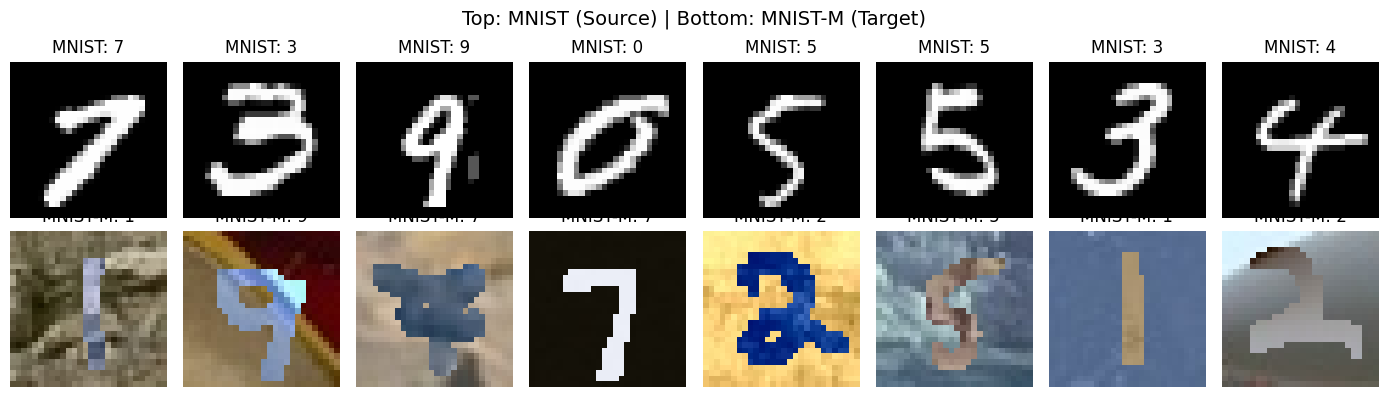

In [ ]:
import matplotlib.pyplot as plt

mnist_imgs, mnist_labels = next(iter(mnist_loader))
mnist_m_imgs, mnist_m_labels = next(iter(mnist_m_loader))

fig, axes = plt.subplots(2, 8, figsize=(14, 4))

for i in range(8):
    # MNIST
    axes[0, i].imshow(denormalize(mnist_imgs[i]).permute(1, 2, 0))
    axes[0, i].set_title(f"MNIST: {mnist_labels[i].item()}")
    axes[0, i].axis('off')

    # MNIST-M
    axes[1, i].imshow(denormalize(mnist_m_imgs[i]).permute(1, 2, 0))
    axes[1, i].set_title(f"MNIST-M: {mnist_m_labels[i]}")
    axes[1, i].axis('off')

plt.suptitle("Top: MNIST (Source) | Bottom: MNIST-M (Target)", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
source_loader = mnist_loader
target_loader = mnist_m_loader

In [ ]:
# ----------------------------
# Models: Feature Extractor, Label Classifier, Domain Discriminator
# ----------------------------
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 48, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.conv(x).view(x.size(0), -1)

class LabelClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(48 * 4 * 4, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, feat):
        return self.fc(feat)

class DomainDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(48 * 4 * 4, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, feat):
        return self.fc(feat)


class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

def grad_reverse(x, alpha=1.0):
    return GradReverse.apply(x, alpha)

In [ ]:
# Initialize models
F = FeatureExtractor().to(device)
C = LabelClassifier().to(device)
D = DomainDiscriminator().to(device)

# Losses and optimizers
criterion_class = nn.CrossEntropyLoss()
criterion_domain = nn.BCELoss()
optimizer_FC = optim.Adam(list(F.parameters()) + list(C.parameters()), lr=2e-4)
optimizer_D = optim.Adam(D.parameters(), lr=2e-4)


In [ ]:
# ----------------------------
# Training Loop
# ----------------------------
epochs = 10
for epoch in range(1, epochs + 1):
    F.train(); C.train(); D.train()
    tgt_iter = iter(target_loader)

    for i, (x_s, y_s) in enumerate(source_loader):
        x_s, y_s = x_s.to(device), y_s.to(device)

        try:
            x_t, _ = next(tgt_iter)
        except:
            tgt_iter = iter(target_loader)
            x_t, _ = next(tgt_iter)
        x_t = x_t.to(device)

        # Forward
        x = torch.cat([x_s, x_t], dim=0)
        feat = F(x)

        # Classification loss on source
        pred_class = C(feat[:x_s.size(0)])
        loss_class = criterion_class(pred_class, y_s)

        # Domain loss on both source and target
        feat_rev = grad_reverse(feat, alpha=1.0)
        domain_labels = torch.cat([torch.ones(x_s.size(0), 1), torch.zeros(x_t.size(0), 1)], dim=0).to(device)
        pred_domain = D(feat_rev)
        loss_domain = criterion_domain(pred_domain, domain_labels)

        # Update networks
        optimizer_FC.zero_grad()
        optimizer_D.zero_grad()
        loss = loss_class + loss_domain
        loss.backward()
        optimizer_FC.step()
        optimizer_D.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch [{i}] Class Loss: {loss_class.item():.4f} Domain Loss: {loss_domain.item():.4f}")


Epoch [1/10] Batch [0] Class Loss: 2.3127 Domain Loss: 0.7003
Epoch [1/10] Batch [100] Class Loss: 1.1928 Domain Loss: 0.6776
Epoch [1/10] Batch [200] Class Loss: 0.2908 Domain Loss: 0.4556
Epoch [1/10] Batch [300] Class Loss: 0.2177 Domain Loss: 0.3987
Epoch [1/10] Batch [400] Class Loss: 0.1917 Domain Loss: 0.2905
Epoch [1/10] Batch [500] Class Loss: 0.0384 Domain Loss: 0.1942
Epoch [1/10] Batch [600] Class Loss: 0.7350 Domain Loss: 0.4753
Epoch [1/10] Batch [700] Class Loss: 0.1681 Domain Loss: 0.6928
Epoch [1/10] Batch [800] Class Loss: 0.0584 Domain Loss: 0.3852
Epoch [1/10] Batch [900] Class Loss: 0.6869 Domain Loss: 0.6277
Epoch [1/10] Batch [1000] Class Loss: 0.0498 Domain Loss: 0.4054
Epoch [1/10] Batch [1100] Class Loss: 0.2612 Domain Loss: 0.3940
Epoch [1/10] Batch [1200] Class Loss: 0.1759 Domain Loss: 0.4892
Epoch [1/10] Batch [1300] Class Loss: 0.0420 Domain Loss: 0.5382
Epoch [1/10] Batch [1400] Class Loss: 0.2454 Domain Loss: 0.3921
Epoch [1/10] Batch [1500] Class Loss:

In [ ]:
# Use the same transformation used during training
transform_mnist_m = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load MNIST-M test set
mnist_m_test = MNISTM(root='./data', train=False, download=False, transform=transform_mnist_m)
test_loader = DataLoader(mnist_m_test, batch_size=64, shuffle=False)

./data/MNISTM/processed/mnist_m_test.pt


In [ ]:
def evaluate_on_target(F, C, test_loader):
    F.eval()
    C.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            features = F(x)
            preds = C(features)
            predicted = preds.argmax(1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    acc = 100 * correct / total
    print(f"Target Domain (MNIST-M Test) Accuracy: {acc:.2f}%")
    return acc

In [ ]:
evaluate_on_target(F, C, test_loader)

Target Domain (MNIST-M Test) Accuracy: 75.80%


75.8